In [2]:
import os
import numpy as np
from tqdm import tqdm

import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions

from btk.sampling_functions import DefaultSampling, SamplingFunction
from btk.utils import DEFAULT_SEED
from typing import Optional, Tuple
from astropy.table import Table

import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb

/lustre/fswork/projects/rech/tkc/commun/venv/a100/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CATSim Catalog

In [3]:
catalog_name = "../data/input_catalog.fits" # contains ~85k entries
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
catalog.table[:5] # display 5 first entries of table containing the actual catalog information.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995
2208734677,0.42108619213,-7.25999998394e-05,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883
2212241881,0.423181056976,-0.00218109996058,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602


### Sampling Function with Shear

In [4]:
class SamplingShear(DefaultSampling):
    def __init__(
        self,
        stamp_size: float = 24.0,
        max_number: int = 2,
        min_number: int = 1,
        max_shift: Optional[float] = None,
        seed=DEFAULT_SEED,
        max_mag: float = 25.3,
        min_mag: float = -np.inf,
        mag_name: str = "i_ab",
        sigma: float = 0.02,
    ):
        """Initializes default sampling function with shear.

        Args:
            stamp_size: Defined in parent class.
            max_number: Defined in parent class.
            min_number: Defined in parent class.
            stamp_size: Defined in parent class.
            max_shift: Defined in parent class.
            seed: Defined in parent class.
            max_mag: Defined in parent class.
            min_mag: Defined in parent class.
            mag_name: Defined in parent class.
            shear: Constant (g1,g2) shear to apply to every galaxy.
        """
        super().__init__(
            stamp_size, max_number, min_number, max_shift, seed, max_mag, min_mag, mag_name
        )
        
        self.sigma = sigma
        
    def __call__(self, table: Table, **kwargs) -> Table:
        """Same as corresponding function for `DefaultSampling` but adds shear to output tables."""
        blend_table = super().__call__(table)
        theta = np.random.uniform(0, np.pi)
        shear = np.random.rayleigh(scale=self.sigma)
        # blend_table["g1"] = shear * np.cos(2 * theta)
        # blend_table["g2"] = shear * np.sin(2 * theta)

        blend_table["g1"] = 0.1
        blend_table["g2"] = 0.0
        return blend_table

class PairSamplingShear(SamplingFunction):
    """Sampling function for pairs of galaxies. Picks one centered bright galaxy and second dim.

    The bright galaxy is centered at the center of the stamp and the dim galaxy is shifted.
    The bright galaxy is chosen with magnitude less than `bright_cut` and the dim galaxy
    is chosen with magnitude cut larger than `bright_cut` and less than `dim_cut`. The cuts
    can be customized by the user at initialization.

    """

    def __init__(
        self,
        stamp_size: float = 24.0,
        max_shift: Optional[float] = None,
        mag_name: str = "i_ab",
        seed: int = DEFAULT_SEED,
        bright_cut: float = 25.3,
        dim_cut: float = 28.0,
        sigma: float = 0.02,
    ):
        """Initializes the PairSampling function.

        Args:
            stamp_size: Size of the desired stamp (in arcseconds).
            max_shift: Maximum value of shift from center. If None then its set as one-tenth the
                stamp size (in arcseconds).
            mag_name: Name of the magnitude column in the catalog to be used.
            seed: See parent class.
            bright_cut: Magnitude cut for bright galaxy. (Default: 25.3)
            dim_cut: Magnitude cut for dim galaxy. (Default: 28.0)
        """
        super().__init__(stamp_size, 2, 1, seed)
        self.stamp_size = stamp_size
        self.max_shift = max_shift if max_shift is not None else self.stamp_size / 10.0
        self.mag_name = mag_name
        self.bright_cut = bright_cut
        self.dim_cut = dim_cut
        
        shear = np.random.rayleigh(scale=sigma)
        self.shear = shear
    
    def __call__(self, table: Table):
        """Samples galaxies from input catalog to make blend scene."""
        if self.mag_name not in table.colnames:
            raise ValueError(f"Catalog must have '{self.mag_name}' column.")

        (q_bright,) = np.where(table[self.mag_name] <= self.bright_cut)
        (q_dim,) = np.where(
            (table[self.mag_name] > self.bright_cut) & (table[self.mag_name] <= self.dim_cut)
        )

        indexes = [np.random.choice(q_bright), np.random.choice(q_dim)]
        blend_table = table[indexes]

        blend_table["ra"] = 0.0
        blend_table["dec"] = 0.0

        x_peak, y_peak = btk.sampling_functions._get_random_center_shift(1, self.max_shift, self.rng)

        blend_table["ra"][1] += x_peak
        blend_table["dec"][1] += y_peak

        btk.sampling_functions._raise_error_if_out_of_bounds(blend_table["ra"], blend_table["dec"], self.stamp_size)
        
        theta = np.random.uniform(0, np.pi)
        blend_table["g1"] = self.shear * np.cos(2 * theta)
        blend_table["g2"] = self.shear * np.sin(2 * theta)

        return blend_table

In [5]:
stamp_size = 9.0  # Size of the stamp, in arcseconds
max_number = 1    # Maximum number of galaxies in a blend
max_shift = 0    # Maximum shift of the galaxies, in arcseconds
seed = 10 # random seed for reproducibility purposes 
sigma = 0.02
bright_cut = 25.3
dim_cut = 28

# sampling_function = SamplingShear(
#     max_number=max_number, min_number=max_number,  # always get `max_number` galaxies
#     stamp_size=stamp_size, max_shift=max_shift,
#     # min_mag = 24, max_mag = 25,
#     seed = seed,
#     sigma=0.1
# )

sampling_function = DefaultSampling(
    max_number=max_number, min_number=max_number,  # always get `max_number` galaxies
    stamp_size=stamp_size, max_shift=max_shift,
    seed = seed,
)

# sampling_function = PairSamplingShear(
#     stamp_size=stamp_size, max_shift=max_shift,
#     seed = seed, 
#     sigma=sigma, bright_cut=bright_cut, dim_cut=dim_cut
# )

In [6]:
blend_catalog = sampling_function(catalog.table)
blend_catalog # ra and dec are now relative to the center of the blend (not the original ones)

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
402700815170,0.0,0.0,0.360406905413,0.0,2.45262194908e-17,0.0,0.0,0.525214195251,0.0,0.248183995485,0.0,29.5103092194,26.1082515717,24.6476840973,23.4332103729,23.0453739166,22.8311138153,22.693025589


### LSST Survey

In [7]:
LSST = btk.survey.get_surveys("LSST")

In [8]:
print(LSST)

--------
| LSST | Legacy Survey of Space and Time (LSST) done with the Simonyi survey telescope and the LSST camera
--------
  pixel_scale          = 0.2 arcsec
  mirror_diameter      = 8.36 m
  gain                 = 1.0 electron / adu
  obscuration          = 0.39257227
  zeropoint_airmass    = 1.2
  available_filters    = ['u', 'g', 'r', 'i', 'z', 'y']
  effective_area       = 33.342414830068996 m2


### Images Generator

In [9]:
batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    njobs=1,
    add_noise="none",
    seed=seed, # use same seed here
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

In [10]:
blend_batch.blend_images.shape

(100, 6, 45, 45)

### Shear

In [11]:
from btk.measure import get_ksb_ellipticity

In [1]:
#obtaining images
iso_images1 = blend_batch.isolated_images[:,:, 2] # only r-band
psf_r =blend_batch.psf[2] # psf in r-band

b, ms1, _, _ = iso_images1.shape

# need their centroids need to measure ellipticity
centroids1 = np.zeros((b, ms1, 2))
for ii, t in enumerate(blend_batch.catalog_list):
    n_sources = len(t["x_peak"])
    centroids1[ii, :n_sources, 0] = t["x_peak"].value
    centroids1[ii, :n_sources, 1] = t["y_peak"].value

#compute ellipticity
ellips1 = get_ksb_ellipticity(iso_images1, centroids1, psf_r, pixel_scale=0.2)

NameError: name 'blend_batch' is not defined

In [16]:
psf_r

galsim.Convolution([galsim.Kolmogorov(lam_over_r0=0.8300341781257276, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), galsim.Airy(lam_over_diam=0.01541992267333556, obscuration=0.6265558793914554, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05))], real_space=False, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

In [47]:
e1 = ellips1[:,0,0]
e2 = ellips1[:,0,1]

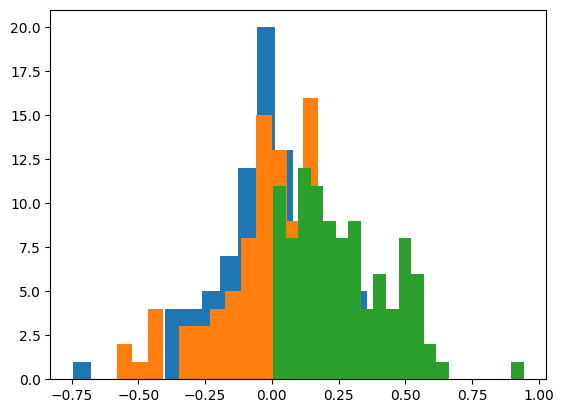

In [53]:
plt.hist(e1, bins=20)
plt.hist(e2, bins=20)

plt.hist(np.sqrt(e1**2 + e2**2), bins=20)
plt.show()

### Take a look at the data

In [14]:
blend_batch.catalog_list[0]

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,x_peak,y_peak,btk_rotation,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
402700868066,0.0,0.0,1.53247404099,4.15275397261e-18,2.2147499512e-17,0.0,0.279117792845,0.663158297539,0.272092789412,0.519530415535,124.863945007,124.863945007,23.4972915649,23.4982757568,23.5343933105,23.3882274628,23.2130355835,22.8385848999,22.0,21.99999999993685,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
len_batch = blend_batch.blend_images.shape[0]
# g1 = np.empty(len_batch)
# g2 = np.empty(len_batch)
redshift = np.empty(len_batch)
r_ab = np.empty(len_batch)

for i in range(len_batch):
    # g1[i] = blend_batch.catalog_list[i]["g1"].value[0]
    # g2[i] = blend_batch.catalog_list[i]["g2"].value[0]
    redshift[i] = blend_batch.catalog_list[i]["redshift"].value[0]
    r_ab[i] = blend_batch.catalog_list[i]["r_ab"].value[0]
    
# g = np.sqrt(g1**2 + g2**2)

/lustre/fswork/projects/rech/tkc/commun/venv/a100/lib64/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: overflow encountered in divide
  return n/db/n.sum(), bin_edges


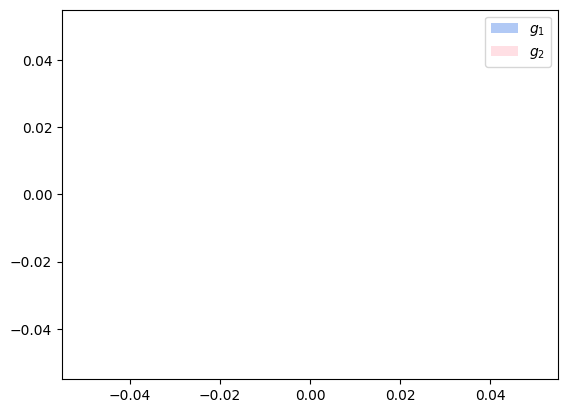

In [18]:
plt.figure()

plt.hist(g1, bins=50, density=True, color="cornflowerblue", alpha=0.5, label="$g_1$")
plt.hist(g2, bins=50, density=True, color="pink", alpha=0.5, label="$g_2$")
plt.legend()

plt.show()

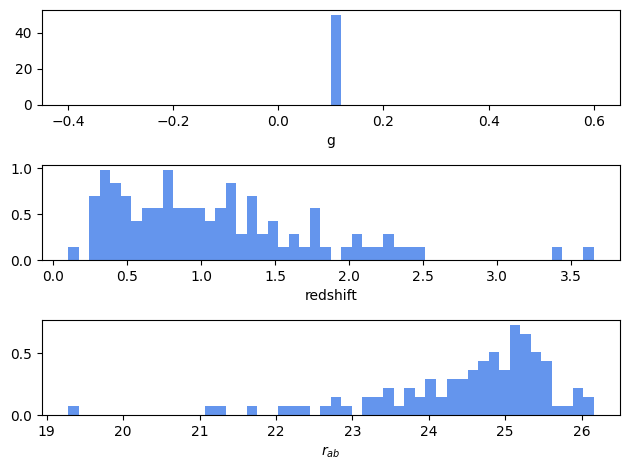

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.hist(g, bins=50, density=True, color="cornflowerblue")
ax1.set_xlabel("g")

ax2.hist(redshift, bins=50, density=True, color="cornflowerblue")
ax2.set_xlabel("redshift")

ax3.hist(r_ab, bins=50, density=True, color="cornflowerblue")
ax3.set_xlabel(r"$r_{ab}$")

plt.tight_layout()
plt.show()

NameError: name 'g1' is not defined

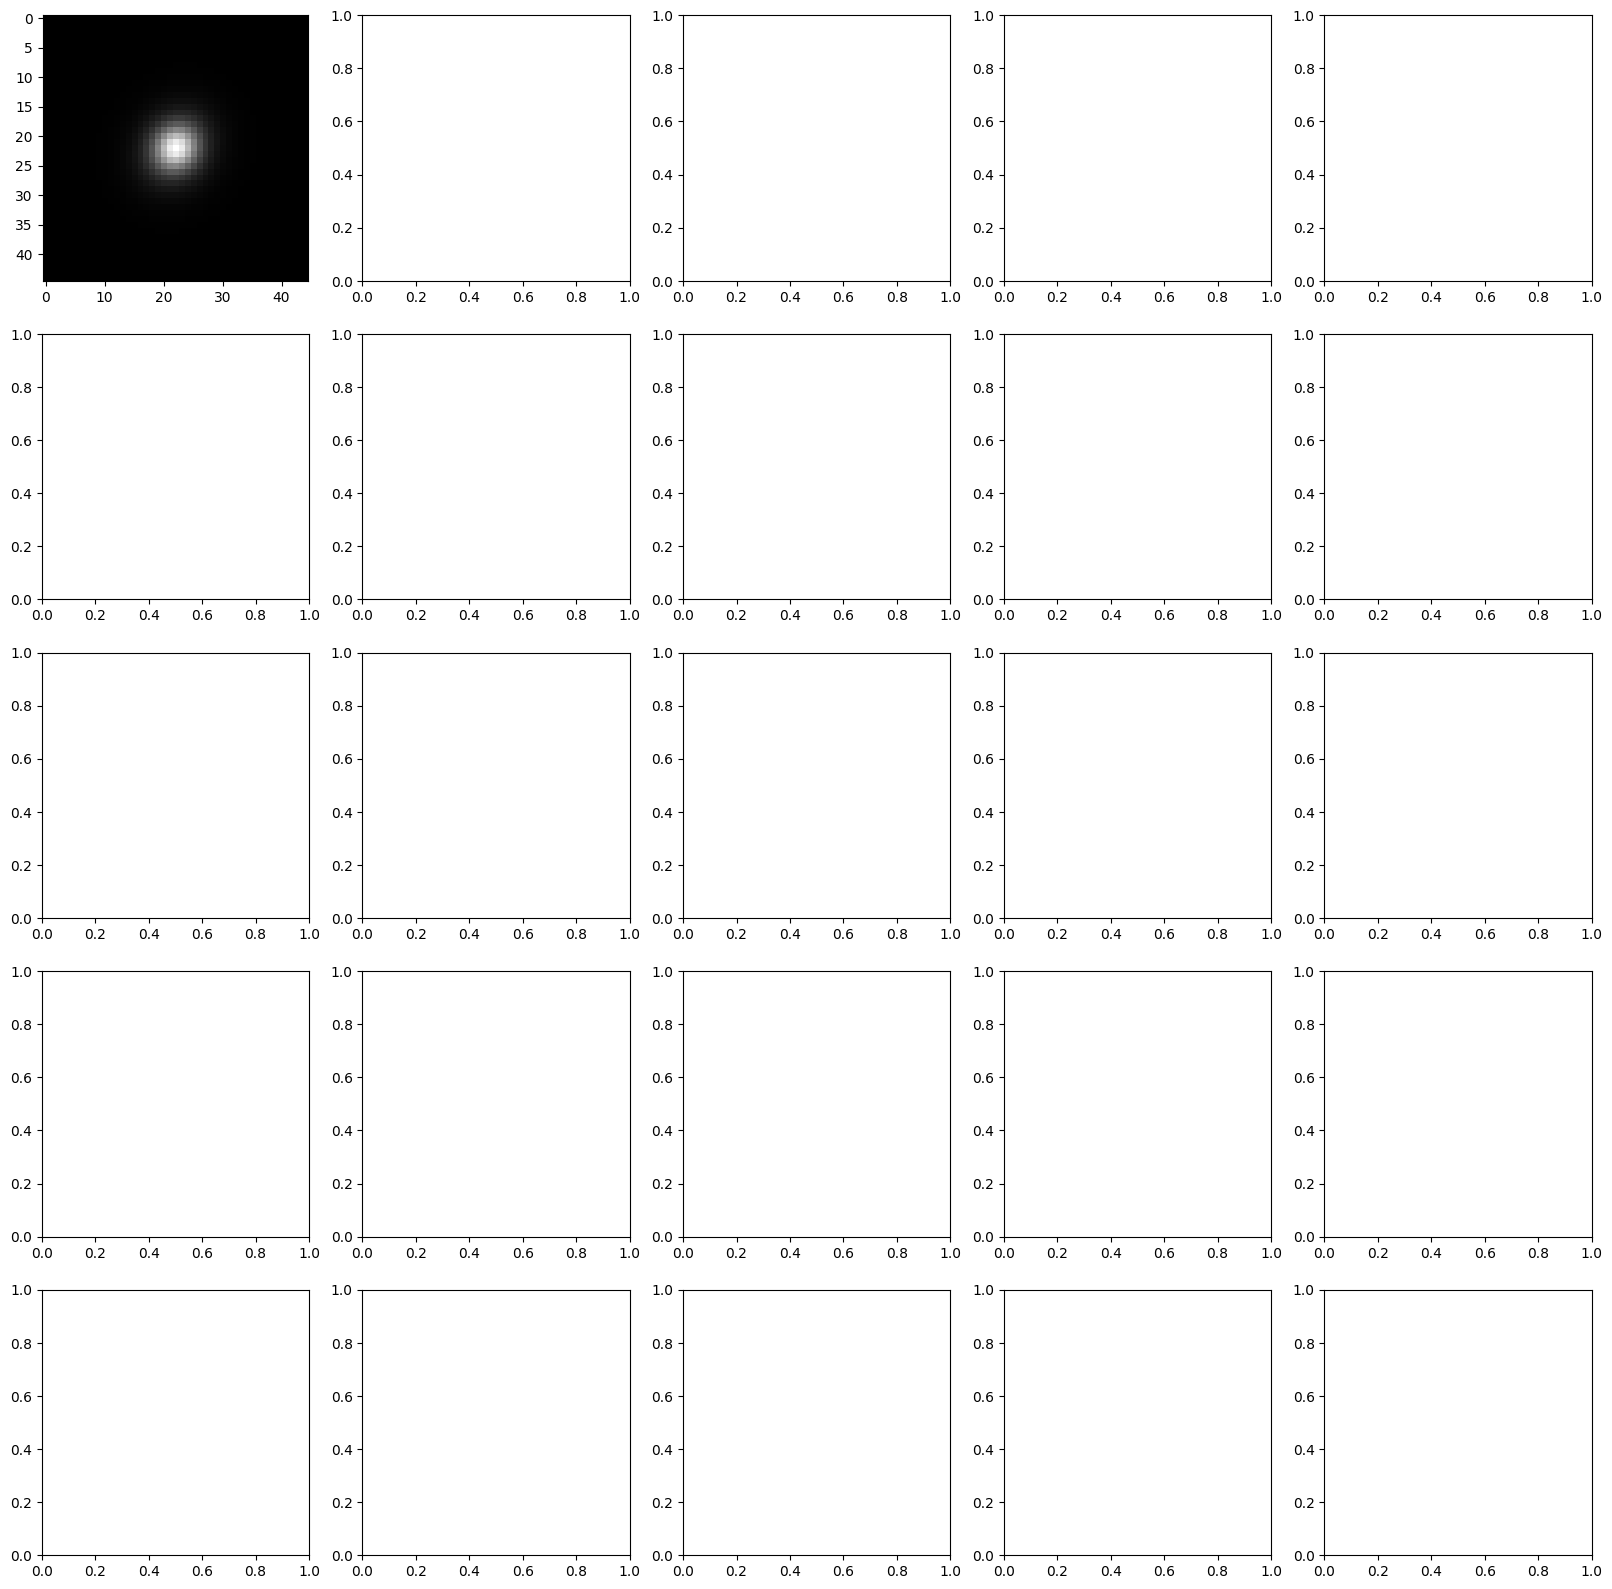

In [37]:
# plot the first blend in the batch, with the r-band
fig, ax = plt.subplots(5, 5, figsize=(20,20))

for i in range(5):
    for j in range(5):
        k = 5 * i + j
        ax[i, j].imshow(blend_batch.blend_images[k, 2, :, :], cmap="gray")
        ax[i, j].set_title(f"g1 = {g1[k]:.4f}, g2 = {g2[k]:.4f}")
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

## Test functions

In [5]:
def generate_data(store_path, num_images, batch_size, dataset_type, seed=28):
    """
    Generate isolated galaxy images and save them in the given directory.
    
    Args:
        store_path (str): Path to store the dataset.
        num_images (int): Total number of images to generate.
        batch_size (int): Number of images per batch.
        dataset_type (str): "training" or "validation".
        seed (int): Random seed for reproducibility.
    """
    catalog_name = "../data/input_catalog.fits"  # Adjust path if needed
    catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
    
    stamp_size = 9  # in arcseconds
    max_number = 1  # Isolated galaxies
    max_shift = 0  # No shift
    
    sampling_function = btk.sampling_functions.SamplingShear(
        max_number=max_number, min_number=max_number,
        stamp_size=stamp_size, max_shift=max_shift,
        seed=seed, sigma=0.02
    )
    
    LSST = btk.survey.get_surveys("LSST")
    
    output_dir = os.path.join(store_path, dataset_type)
    os.makedirs(output_dir, exist_ok=True)
    
    num_batches = num_images // batch_size
    seed_offset = np.random.randint(1e6)  # Random initial offset for diversity
    
    for i in tqdm(range(num_batches), desc=f"Generating {dataset_type} data"):
        draw_generator = btk.draw_blends.CatsimGenerator(
            catalog, sampling_function, LSST,
            batch_size=batch_size, njobs=1,
            add_noise="none", seed=seed_offset + i  # Different seed for each batch
        )
        blend_batch = next(draw_generator)
        blend_batch.save(output_dir, i)

In [ ]:
SCRATCH = os.getenv("ALL_SCRATCH", "../data")  # Default path if $STORE is not set
SCRATCH = os.path.join(SCRATCH, "deblending")

generate_data(SCRATCH, 1000, 1000, "training")

Generating training_2 data: 100%|██████████| 1/1 [00:15<00:00, 15.16s/it]


## VAE

In [54]:
btkloaded_batch = btk.blend_batch.BlendBatch.load("/batches",0)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/batches/blend_0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
btkloaded_batch.blend_images.shape

(1000, 6, 60, 60)